In [2]:
#############
# LIBRARIES #
#############

from get_strava_data import my_data, process_data, bike_data, get_elevation # Functions to retrive data using strava api and process for visualizations

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import calplot
# import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [9]:
# Opening activities data

processed_data = pd.read_csv('./data/processed_data.csv')
processed_data.head()

,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date_local,achievement_count,...,pr_count,total_photo_count,suffer_score,average_temp,year,month,day,weekday,hour,elev_gain_per_mile
0,Zwift - 2 by 2 in Watopia,7.5,0.5,0.5,324.8,VirtualRide,VirtualRide,8491181626,02-01-2023,1,...,0,0,23.0,NaN,2023,2,1,Wednesday,20,43.3
1,Alameda & Bay Farm,26.4,1.5,1.6,157.5,Ride,Ride,8485072654,01-31-2023,10,...,3,2,140.0,16.0,2023,1,31,Tuesday,14,6.0
2,Evening Weight Training,0.0,0.3,0.3,0.0,WeightTraining,WeightTraining,8479862220,01-30-2023,0,...,0,0,3.0,NaN,2023,1,30,Monday,19,NaN
3,Zwift - Roger Lefort s Meetup on Wandering Fla...,18.5,1.0,1.1,505.2,VirtualRide,VirtualRide,8474322131,01-29-2023,1,...,0,0,9.0,NaN,2023,1,29,Sunday,14,27.3
4,Grizzly Peak via Tunnel w/ TA,41.2,3.1,4.1,2582.0,Ride,Ride,8467691962,01-28-2023,38,...,0,0,77.0,13.0,2023,1,28,Saturday,8,62.7


In [4]:
processed_data.columns

Index(['name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'sport_type', 'id', 'start_date_local',
       'achievement_count', 'kudos_count', 'comment_count', 'photo_count',
       'map', 'trainer', 'gear_id', 'average_speed', 'max_speed',
       'average_cadence', 'average_watts', 'max_watts',
       'weighted_average_watts', 'kilojoules', 'average_heartrate',
       'max_heartrate', 'elev_high', 'pr_count', 'total_photo_count',
       'suffer_score', 'average_temp', 'year', 'month', 'day', 'weekday',
       'hour', 'elev_gain_per_mile'],
      dtype='object')

In [10]:
# Keepping only outdoor rides
only_rides = processed_data[processed_data.type == 'Ride']

new_york_era = only_rides[only_rides.year < 2021]
san_francisco_era = only_rides[only_rides.year >= 2021]

In [23]:
# Avg speed by year
avg_speed_by_year = only_rides.groupby('year').agg({'distance': 'sum', 'moving_time': 'sum', 'average_watts': 'mean'}).reset_index()
avg_speed_by_year['avg_speed'] = round(avg_speed_by_year['distance'] / avg_speed_by_year['moving_time'], 1)
avg_speed_by_year

,year,distance,moving_time,average_watts,avg_speed
0,2012,886.0,82.0,65.478947,10.8
1,2013,747.1,66.8,71.857895,11.2
2,2014,857.5,65.0,95.046154,13.2
3,2015,2105.3,161.5,87.243038,13.0
4,2016,1465.0,113.9,89.996825,12.9
5,2017,656.2,50.9,87.300000,12.9
6,2018,851.1,65.6,108.108333,13.0
7,2019,278.5,22.4,103.086667,12.4
8,2020,1899.0,136.8,114.501266,13.9
9,2021,2224.5,171.3,121.162105,13.0


In [16]:
# New York
NY_total_distance = new_york_era.distance.sum()
NY_total_time = new_york_era.moving_time.sum()
NY_avg_speed = NY_total_distance / NY_total_time

# San Francisco
SF_total_distance = san_francisco_era.distance.sum()
SF_total_time = san_francisco_era.moving_time.sum()
SF_avg_speed = SF_total_distance / SF_total_time

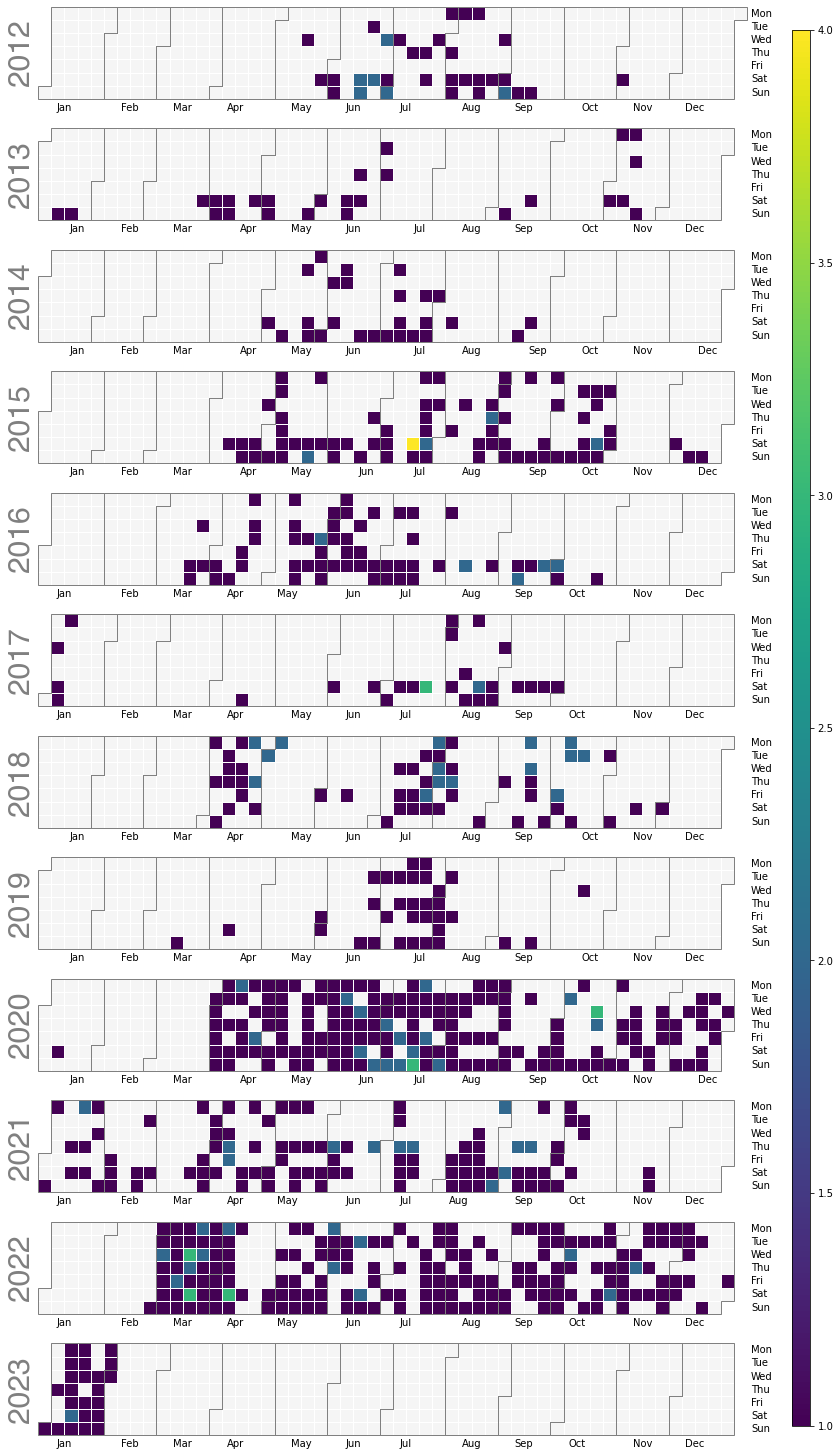

In [36]:
# Create a calplot calendar with the number of activities per day
# Grouping by day and counting the number of activities
grouped_by_day = processed_data.groupby('start_date_local').agg({'id': 'count'}).reset_index()
# Converting to datetime
grouped_by_day.start_date_local = pd.to_datetime(grouped_by_day.start_date_local)
# # Set activity date as index
grouped_by_day.set_index('start_date_local', inplace=True)
grouped_by_day.head()

# Creating the calcplot calendar
plot = calplot.calplot(data=grouped_by_day.id, how='sum')

In [314]:
grouped_by_day_and_type = processed_data.groupby(['start_date_local', 'type']).agg({'id': 'count'}).reset_index()
# Converting to datetime
grouped_by_day_and_type.start_date_local = pd.to_datetime(grouped_by_day_and_type.start_date_local)
# Set activity date as index
grouped_by_day_and_type.set_index('start_date_local', inplace=True)
# Drop duplicate index
grouped_by_day_and_type = grouped_by_day_and_type[~grouped_by_day_and_type.index.duplicated(keep='first')]

grouped_by_day_and_type = grouped_by_day_and_type.reindex(pd.date_range(start=grouped_by_day_and_type.index.min(), end=grouped_by_day_and_type.index.max()), fill_value=0)
# # Replacing 0 with na
# grouped_by_day_and_type.id = grouped_by_day_and_type.id.replace(0, np.nan)
# grouped_by_day_and_type.id = grouped_by_day_and_type.id.notnull().astype('int')
grouped_by_day_and_type

,type,id
2012-05-16,Ride,1
2012-05-17,0,0
2012-05-18,0,0
2012-05-19,0,0
2012-05-20,0,0
...,...,...
2023-01-28,Ride,1
2023-01-29,VirtualRide,1
2023-01-30,WeightTraining,1
2023-01-31,Ride,1


In [322]:
grouped_by_day_and_type['active'] = np.where(grouped_by_day_and_type.id ==1, 1, 0)
# Summing the number of active days until next inactive day
grouped_by_day_and_type['streak'] = grouped_by_day_and_type.active.groupby((grouped_by_day_and_type.active != grouped_by_day_and_type.active.shift()).cumsum()).cumsum()
grouped_by_day_and_type

,type,id,active,streak
2012-05-16,Ride,1,1,1
2012-05-17,0,0,0,0
2012-05-18,0,0,0,0
2012-05-19,0,0,0,0
2012-05-20,0,0,0,0
...,...,...,...,...
2023-01-28,Ride,1,1,4
2023-01-29,VirtualRide,1,1,5
2023-01-30,WeightTraining,1,1,6
2023-01-31,Ride,1,1,7


In [290]:
grouped_by_day_and_type = grouped_by_day_and_type.reset_index()
grouped_by_day_and_type = grouped_by_day_and_type.rename(columns={'index': 'start_date_local'})
grouped_by_day_and_type

,start_date_local,type,id
0,2012-05-16,Ride,1
1,2012-05-17,0,0
2,2012-05-18,0,0
3,2012-05-19,0,0
4,2012-05-20,0,0
...,...,...,...
3909,2023-01-28,Ride,1
3910,2023-01-29,VirtualRide,1
3911,2023-01-30,WeightTraining,1
3912,2023-01-31,Ride,1


In [307]:
# Difference between two dates
grouped_by_day_and_type['is_consecutive'] = grouped_by_day_and_type.id.eq(1) & grouped_by_day_and_type.start_date_local.diff().dt.days.ne(0)
grouped_by_day_and_type

,start_date_local,type,id,is_consecutive,streak
0,2012-05-16,Ride,1,True,1.0
1,2012-05-17,0,0,False,0.0
2,2012-05-18,0,0,False,0.0
3,2012-05-19,0,0,False,0.0
4,2012-05-20,0,0,False,0.0
...,...,...,...,...,...
3909,2023-01-28,Ride,1,True,NaN
3910,2023-01-29,VirtualRide,1,True,NaN
3911,2023-01-30,WeightTraining,1,True,NaN
3912,2023-01-31,Ride,1,True,NaN


In [303]:
grouped_by_day_and_type

,start_date_local,type,id,is_consecutive,streak
0,2012-05-16,Ride,1,True,1.0
1,2012-05-17,0,0,False,0.0
2,2012-05-18,0,0,False,0.0
3,2012-05-19,0,0,False,0.0
4,2012-05-20,0,0,False,0.0
...,...,...,...,...,...
3909,2023-01-28,Ride,1,True,NaN
3910,2023-01-29,VirtualRide,1,True,NaN
3911,2023-01-30,WeightTraining,1,True,NaN
3912,2023-01-31,Ride,1,True,NaN


In [308]:
# Finding when streak started and ended


streaks = grouped_by_day_and_type.is_consecutive.groupby((grouped_by_day_and_type.is_consecutive != grouped_by_day_and_type.is_consecutive.shift()).cumsum()).sum()

streaks


is_consecutive
1      1
2      0
3      1
4      0
5      2
      ..
785    4
786    0
787    3
788    0
789    8
Name: is_consecutive, Length: 789, dtype: int64

In [298]:
# Finding the date of the streaks
longest_streak = streaks[streaks == streaks.max()].index[0]
longest_streak


651

In [388]:
grouped_by_day_and_type = processed_data.groupby(['start_date_local', 'type']).agg({'id': 'count'}).reset_index()
# grouped_by_day = processed_data.groupby('start_date_local').agg({'id': 'count'}).reset_index()
# Converting to datetime
grouped_by_day_and_type.start_date_local = pd.to_datetime(grouped_by_day_and_type.start_date_local)
# # Set activity date as index
grouped_by_day_and_type.set_index('start_date_local', inplace=True)
# Drop duplicate index
grouped_by_day_and_type = grouped_by_day_and_type[~grouped_by_day_and_type.index.duplicated(keep='first')]
# Reindexing to fill in missing dates
# grouped_by_day_and_type = grouped_by_day_and_type.reindex(pd.date_range(start=grouped_by_day_and_type.index.min(), end=grouped_by_day_and_type.index.max()), fill_value=np.nan)
# Replacing 0 with na --days with multiple activities will be counted as 1
# grouped_by_day_and_type.id = grouped_by_day_and_type.id.replace(0, np.nan)
grouped_by_day_and_type.id = grouped_by_day_and_type.id.notnull().astype('int')

grouped_by_day_and_type = grouped_by_day_and_type.reset_index()
grouped_by_day_and_type = grouped_by_day_and_type.rename(columns={'index': 'start_date_local'})
grouped_by_day_and_type = grouped_by_day_and_type.sort_values(by='start_date_local', ascending=False)

# Summing the ids where dates are consecutive
grouped_by_day_and_type['days_between_activities'] = grouped_by_day_and_type.start_date_local.diff(-1).dt.days
grouped_by_day_and_type['is_consecutive'] = grouped_by_day_and_type.days_between_activities.eq(1)
grouped_by_day_and_type['streak'] = grouped_by_day_and_type.is_consecutive.groupby((grouped_by_day_and_type.is_consecutive != grouped_by_day_and_type.is_consecutive.shift()).cumsum()).cumsum()

grouped_by_day_and_type


,start_date_local,type,id,days_between_activities,is_consecutive,streak
40,2023-02-01,VirtualRide,1,1.0,True,1
39,2023-01-31,Ride,1,1.0,True,2
37,2023-01-30,WeightTraining,1,1.0,True,3
36,2023-01-29,VirtualRide,1,1.0,True,4
35,2023-01-28,Ride,1,1.0,True,5
...,...,...,...,...,...,...
326,2012-06-16,Ride,1,13.0,False,0
284,2012-06-03,Ride,1,1.0,True,1
280,2012-06-02,Ride,1,7.0,False,0
252,2012-05-26,Ride,1,10.0,False,0


In [389]:
grouped_by_day_and_type[(grouped_by_day_and_type.start_date_local.dt.year == 2023) & (grouped_by_day_and_type.type == 'Ride')]

,start_date_local,type,id,days_between_activities,is_consecutive,streak
39,2023-01-31,Ride,1,1.0,True,2
35,2023-01-28,Ride,1,1.0,True,5
34,2023-01-27,Ride,1,1.0,True,6
32,2023-01-26,Ride,1,1.0,True,7
27,2023-01-21,Ride,1,1.0,True,2
25,2023-01-20,Ride,1,2.0,False,0
21,2023-01-17,Ride,1,1.0,True,2
20,2023-01-16,Ride,1,1.0,True,3
7,2023-01-08,Ride,1,3.0,False,0
4,2023-01-05,Ride,1,4.0,False,0


In [395]:
# Longest ride
longest_ride = processed_data[(processed_data.year == 2023) & (processed_data.type.isin(['Ride']))].distance.max()
longest_ride

41.2